In [44]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, SequentialSampler, DataLoader
from PIL import Image, ImageDraw

from tqdm import tqdm

from transformers import BertTokenizer, BertPreTrainedModel

from pytorch_pretrained_bert.model_attr import BertPooler, BertModel

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()

In [46]:
BATCH_SIZE = 1
NUM_BATCH = 20

MAX_SEQ_LEN = 128

num_layer = 12
num_head = 12

In [47]:
tokenizer = BertTokenizer.from_pretrained('Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two')

In [48]:
inputs = tokenizer([
    'guilty until proven innocent unless you are a jew a nigger or a lover of both',
    'and this is why i end up with nigger trainee doctors who can not speak properly lack basic knowledge of biology'
], return_tensors='pt', max_length=MAX_SEQ_LEN, padding='max_length', truncation=True).to(device)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0], skip_special_tokens=False)
label_ids = torch.tensor([1, 1], dtype=torch.long).to(device)

In [49]:
inputs

{'input_ids': tensor([[  101,  5905,  2127, 10003,  7036,  4983,  2017,  2024,  1037, 16522,
          1037,  9152, 13327,  2030,  1037,  7089,  1997,  2119,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [50]:
tokens = [token for token in tokens if token not in ['[PAD]']]
tokens

['[CLS]',
 'guilty',
 'until',
 'proven',
 'innocent',
 'unless',
 'you',
 'are',
 'a',
 'jew',
 'a',
 'ni',
 '##gger',
 'or',
 'a',
 'lover',
 'of',
 'both',
 '[SEP]']

In [ ]:
def scaled_input(emb, batch_size, num_batch, baseline=None, start_i=None, end_i=None):
    # shape of emb: (num_head, seq_len, seq_len)
    if baseline is None:
        baseline = torch.zeros_like(emb)

    num_points = batch_size * num_batch
    scale = 1.0 / num_points
    if start_i is None:
        step = (emb.unsqueeze(0) - baseline.unsqueeze(0)) * scale # (1, num_head, seq_len, seq_len)
        # n = batch_size * num_batch
        res = torch.cat([torch.add(baseline.unsqueeze(0), step * i) for i in range(num_points)], dim=0) # (n, num_head, seq_len, seq_len)
        return res, step[0]
    else:
        step = (emb - baseline) * scale
        start_emb = torch.add(baseline, step * start_i)
        end_emb = torch.add(baseline, step * end_i)
        step_new = (end_emb.unsqueeze(0) - start_emb.unsqueeze(0)) * scale
        res = torch.cat([torch.add(start_emb.unsqueeze(0), step_new * i) for i in range(num_points)], dim=0)
        return res, step_new[0]

In [57]:
def generate_attr_score(model, dataloader, batch_size, num_batch):
    res_attr = []

    for input_ids, segment_ids, attention_mask, label_ids in tqdm(dataloader):
        layers_attr = []

        for tar_layer in range(num_layer):
            att, baseline_logits, _ = model(input_ids=input_ids, token_type_ids=segment_ids,
                                            attention_mask=attention_mask,
                                            labels=label_ids, tar_layer=tar_layer)
            pred_label = int(torch.argmax(baseline_logits, dim=1))

            scale_att, step = scaled_input(att.data, batch_size, num_batch)
            scale_att.requires_grad_(True)

            attr_all = None
            for j_batch in range(num_batch):
                one_batch_att = scale_att[j_batch * batch_size:(j_batch + 1) * batch_size]
                tar_prob, grad = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=attention_mask,
                                       labels=label_ids, tar_layer=tar_layer, tmp_score=one_batch_att,
                                       pred_label=pred_label)
                grad = grad.sum(dim=0)
                attr_all = grad if attr_all is None else torch.add(attr_all, grad)
            layers_attr.append(attr_all.data)
        res_attr.append(layers_attr)

    return np.array(res_attr).sum(1).sum(1)

In [52]:
class Model_Rational_Label(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = 2
        self.impact_factor = 0.8
        self.bert = BertModel(config, add_pooling_layer=False)
        self.bert_pooler = BertPooler(config)
        self.token_dropout = nn.Dropout(0.1)
        self.token_classifier = nn.Linear(config.hidden_size, 2)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        self.init_weights()

    def forward(self,
                input_ids=None,
                attention_mask=None,
                token_type_ids=None,
                attn=None,
                labels=None,
                tar_layer=None,
                tmp_score=None,
                pred_label=None):
        _, sequence_output, att_score = self.bert(
            input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask,
            output_all_encoded_layers=False,
            tar_layer=tar_layer, tmp_score=tmp_score)

        token_logits = self.token_classifier(self.token_dropout(sequence_output))

        #         mean_pooling = torch.mean(out, 1)
        #         max_pooling, _ = torch.max(out, 1)
        #         embed = torch.cat((mean_pooling, max_pooling), 1)
        embed = self.bert_pooler(sequence_output)
        logits = self.classifier(self.dropout(embed))

        prob = torch.nn.functional.softmax(logits)

        if labels is not None:
            tar_prob = prob[:, labels[0]]

        if tmp_score is None:
            return att_score[0], logits, token_logits
        else:
            # gradient = torch.autograd.grad(torch.unbind(prob[:, labels[0]]), tmp_score)
            gradient = torch.autograd.grad(torch.unbind(prob[:, pred_label]), tmp_score)
            return tar_prob, gradient[0]

In [11]:
model = Model_Rational_Label.from_pretrained('Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two').to(device)
model

Model_Rational_Label(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
     

In [ ]:
if n_gpu > 1:
    model = torch.nn.DataParallel(model)

In [53]:
def return_dataloader(input_ids, token_type_ids, att_masks, labels, batch_size):
    inputs = torch.tensor(input_ids)
    labels = torch.tensor(labels, dtype=torch.long)
    masks = torch.tensor(np.array(att_masks), dtype=torch.uint8)
    data = TensorDataset(inputs, token_type_ids, masks, labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return dataloader

In [54]:
dataloader = return_dataloader(inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask'], label_ids, BATCH_SIZE)
dataloader

/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_19408/1897980149.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(input_ids)
/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_19408/1897980149.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


In [58]:
res_attr = generate_attr_score(
    model,
    dataloader,
    batch_size=BATCH_SIZE,
    num_batch=NUM_BATCH
)
res_attr

  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_19408/1247702725.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(logits)
100%|██████████| 2/2 [00:59<00:00, 29.65s/it]


array([[[-1.82782680e-01, -7.54722655e-01, -8.62513065e-01, ...,
          8.57996821e-01, -3.23527396e-01, -1.73861697e-01],
        [-1.38371423e-01, -7.34005049e-02, -2.08202861e-02, ...,
         -4.23859619e-02, -4.70634364e-02, -7.77770057e-02],
        [-4.14926335e-02, -3.37700360e-03, -1.90051422e-02, ...,
          1.23263686e-03, -6.25570491e-03, -1.38387214e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-1.44612849e+00, -1.49359429e+00, -1.79202080e+00, ...,
         -1.75044143e+00, -1.78614366e+00, -1.37481356e+00],
        [-1.94016122e-03,  7.18313642e-03,  9.33555234e-03, ...,
          3.56297679e-02,  4.19374444e

In [59]:
np.array(res_attr).shape

(2, 128, 128)

In [73]:
total_attr = res_attr[0, :inputs['attention_mask'][0].sum(), :inputs['attention_mask'][0].sum()]
total_attr = total_attr / total_attr.sum()
total_attr.shape

(19, 19)

In [74]:
def plot_parallel(matrix, tokens):
    # Set figsize
    plt.figure(figsize=(12, 8))

    input_len = len(tokens)

    # Vertical lines for the years
    plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=5, color='black', linestyle='--', linewidth=1)

    # Add the BEFORE and AFTER
    plt.text(1, input_len + 1, 'A', fontsize=12, color='black', fontweight='bold')
    plt.text(5, input_len + 1, 'B', fontsize=12, color='black', fontweight='bold')

    # Plot the line for each continent
    for i in range(input_len):
        for j in range(input_len):
            # Add the line to the plot
            plt.plot([1, 5], [i, j], marker='o', label='token', color='blue', linewidth=5 * matrix[i][j])

            # Add label of each continent at each year
            plt.text(
                1 - 0.18,  # x-axis position
                i,  # y-axis position
                tokens[i],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color,
            )

            plt.text(
                5 + 0.06,  # x-axis position
                j,  # y-axis position
                tokens[j],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color
            )
        break

    # Add a title ('\n' allow us to jump lines)
    plt.title(f'AttrAttr scores \n\n\n')

    plt.yticks([])  # Remove y-axis
    plt.box(False)  # Remove the bounding box around plot
    plt.show()  # Display the chart

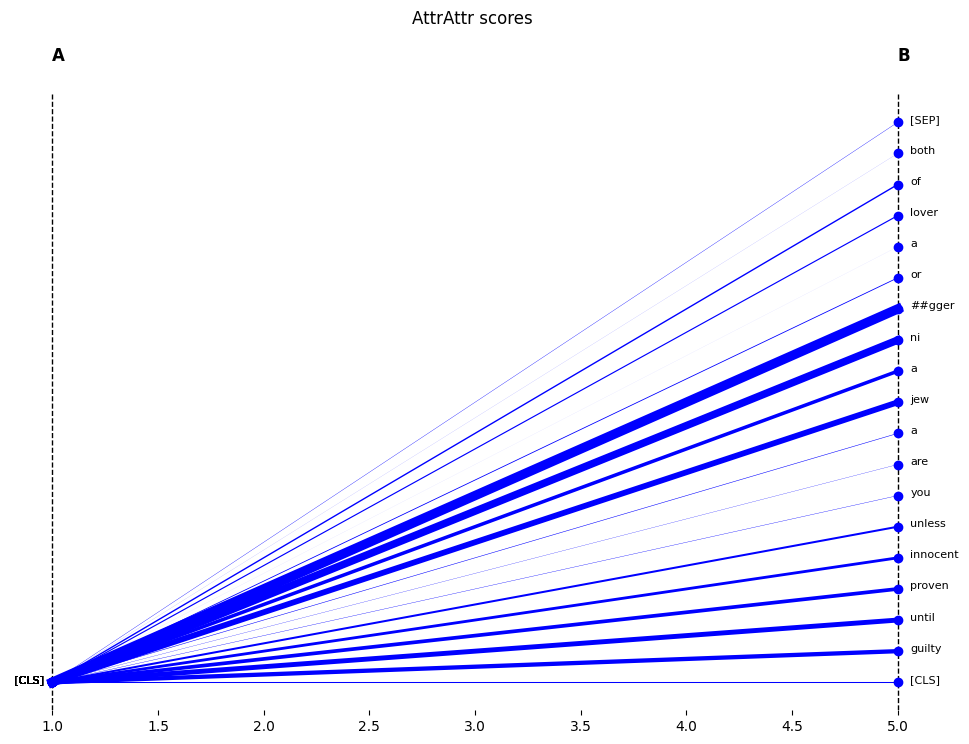

In [75]:
plot_parallel(total_attr, tokens)

In [65]:
_, prediction_logits, token_logits = model(input_ids=inputs['input_ids'], token_type_ids=inputs['token_type_ids'],
                                           attention_mask=inputs['attention_mask'], tar_layer=0)

torch.nn.functional.softmax(prediction_logits)

/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_19408/1247702725.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(logits)
/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_19408/1138532813.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(prediction_logits)


tensor([[0.0231, 0.9769],
        [0.0623, 0.9377]], grad_fn=<SoftmaxBackward0>)

In [66]:
input_len = inputs['attention_mask'][0].sum()

In [67]:
pred_tokens = torch.nn.functional.softmax(token_logits, dim=-1)[:, :input_len, :]
pred_tokens

tensor([[[9.9875e-01, 1.2473e-03],
         [9.9580e-01, 4.1996e-03],
         [9.9657e-01, 3.4278e-03],
         [9.9555e-01, 4.4473e-03],
         [9.9530e-01, 4.7008e-03],
         [9.7589e-01, 2.4106e-02],
         [9.6882e-01, 3.1180e-02],
         [9.7830e-01, 2.1697e-02],
         [9.7018e-01, 2.9817e-02],
         [3.8503e-01, 6.1497e-01],
         [7.4652e-01, 2.5348e-01],
         [2.2920e-02, 9.7708e-01],
         [1.7939e-02, 9.8206e-01],
         [9.2602e-01, 7.3980e-02],
         [9.7907e-01, 2.0928e-02],
         [8.9924e-01, 1.0076e-01],
         [8.9317e-01, 1.0683e-01],
         [9.5001e-01, 4.9993e-02],
         [9.9996e-01, 4.4781e-05]],

        [[9.9961e-01, 3.8629e-04],
         [9.9975e-01, 2.5239e-04],
         [9.9978e-01, 2.1731e-04],
         [9.9978e-01, 2.2005e-04],
         [9.9984e-01, 1.6181e-04],
         [9.9974e-01, 2.5949e-04],
         [9.9962e-01, 3.8302e-04],
         [9.9967e-01, 3.2515e-04],
         [9.9970e-01, 2.9545e-04],
         [3.8896e-

In [68]:
id2label = {
    0: 'NEUTRAL',
    1: 'ABUSIVE'
}

In [69]:
tokens_classes = torch.argmax(pred_tokens, dim=2)[0]

In [70]:
for i, token_label in enumerate(tokens_classes):
    print(f'{tokens[i]} ({id2label[token_label.item()]})', end=' ')

[CLS] (NEUTRAL) guilty (NEUTRAL) until (NEUTRAL) proven (NEUTRAL) innocent (NEUTRAL) unless (NEUTRAL) you (NEUTRAL) are (NEUTRAL) a (NEUTRAL) jew (ABUSIVE) a (NEUTRAL) ni (ABUSIVE) ##gger (ABUSIVE) or (NEUTRAL) a (NEUTRAL) lover (NEUTRAL) of (NEUTRAL) both (NEUTRAL) [SEP] (NEUTRAL) 

In [71]:
def generate_text_highlighted(preds, tokens, canvas=(450, 300)):
    im = Image.new(mode='RGBA', size=canvas, color=(255, 255, 255, 255))

    img = ImageDraw.Draw(im)

    def highlight(xy, wh, color):
        img.rectangle(xy=(xy[0] - 0.5, xy[1] - 0.5, xy[0] + wh[0], xy[1] + wh[1]), fill=color)  # , outline='red'

    # highlight((28, 36), wh=(5, 12), color=(255, 0, 0, 100))
    # img.text((28, 36), 'nice Car', fill=(0, 0, 0, 200))

    x = 28
    y = 36
    for i, token in enumerate(tokens):
        if preds[i] == 1:
            x += 3
            highlight((x, y), wh=(6 * len(token), 12), color=(255, 0, 0, 100))
            img.text((x, y), token, fill=(0, 0, 0, 200))
        else:
            img.text((x, y), token, fill=(0, 0, 0, 255))

        x += 1.4 * 5 * len(token)
        if x + 35 >= canvas[0]:
            x = 28
            y += 1.4 * 7

    return im

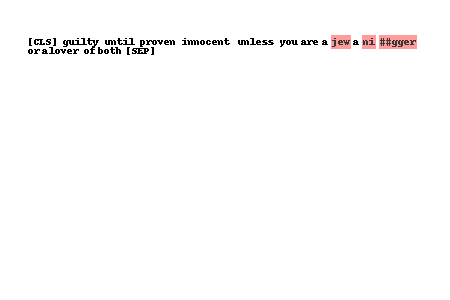

In [72]:
generate_text_highlighted(tokens_classes, tokens)